# Causal Impact in JAX

We illustrate the causal impact library applied to the simple example
which is used in the original <a href="https://google.github.io/CausalImpact/CausalImpact.html">CausalImpact R package</a>
(which is built upon the R package <a href="https://cran.r-project.org/web/packages/bsts/bsts.pdf"> bsts </a> for Bayesian structural time series models).

Note that there are several other packages that implement the causal impact algorithm with python:
* The package <a href="https://github.com/WillianFuks/tfcausalimpact">tfcausalimpact</a> is built upon the <a href="https://www.tensorflow.org/probability/api_docs/python/tfp/sts">tfp.sts module</a>.
* The package <a href="https://pypi.org/project/pycausalimpact/">pycausalimpact</a> is built upon <a href="https://github.com/statsmodels/statsmodels">statsmodels</a>.
* The package <a href="https://github.com/jamalsenouci/causalimpact">causalimpact</a> is build on  <a href="https://www.pymc.io/welcome.html">pymc</a>.



In [2]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt
from sts_jax.causal_impact.causal_impact import causal_impact

2022-12-30 21:49:16.914539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-30 21:49:16.914572: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-30 21:49:16.914575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


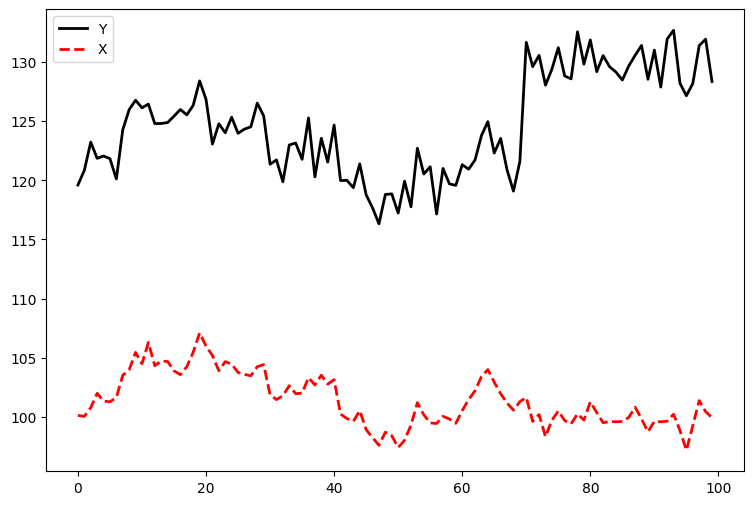

In [3]:
num_timesteps = 100

def auto_regress(x, key):
    x_new = 0.95 * x + jr.normal(key)
    return x_new, x

key = jr.PRNGKey(16)
x0 = jr.normal(key)
keys = jr.split(key, num_timesteps)
_, x =  lax.scan(auto_regress, x0, keys)
x = x + 100

y = 1.2*x + jr.normal(key, shape=(num_timesteps,))
y = y.at[70:].set(y[70:]+10)

plt.figure(figsize=(9, 6))
plt.plot(y, label='Y', color='black', lw=2)
plt.plot(x, linestyle='dashed', color='red', lw=2, label='X')
plt.legend()

In [4]:

obs_time_series = jnp.expand_dims(y, 1)
covariates = jnp.expand_dims(x, 1)
intervention_timepoint = 70

impact = causal_impact(obs_time_series, intervention_timepoint, 'Gaussian', covariates,
                       sts_model=None, confidence_level=0.95, key=jr.PRNGKey(0), num_samples=200)

Running window adaptation


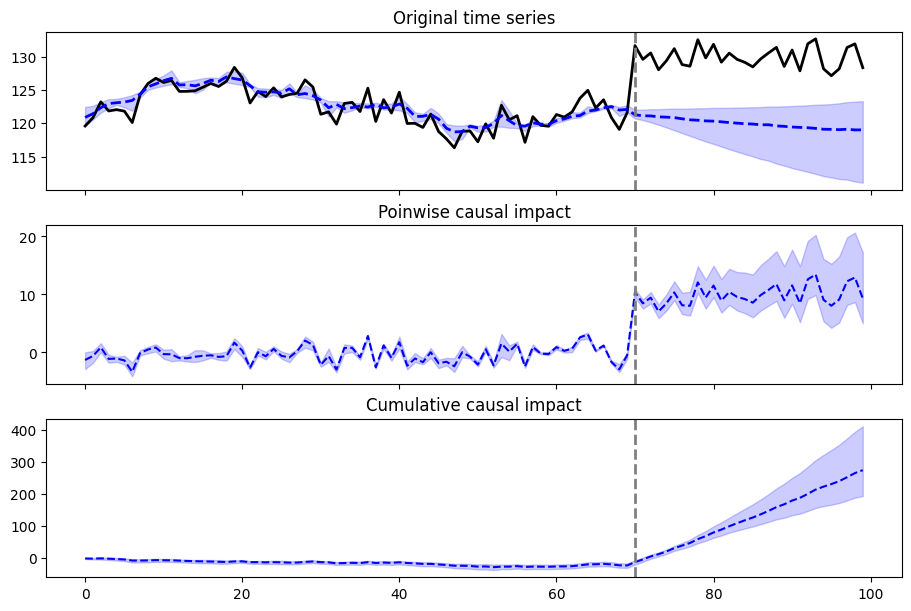

In [5]:
impact.plot()
plt.savefig('causal-impact-3panel.pdf')
plt.show()

In [6]:
impact.print_summary()

Posterior inference of the causal impact:

                               Average            Cumulative     
Actual                          129.93             3897.88       

Prediction (s.d.)           119.98 (1.76)      3599.38 (52.79)   
95% CI                     [115.43, 122.50]   [3463.01, 3674.88] 

Absolute effect (s.d.)       9.95 (1.76)        298.50 (52.79)   
95% CI                      [7.43, 14.50]      [223.00, 434.86]  

Relative effect (s.d.)      8.32% (1.63%)       8.32% (1.63%)    
95% CI                     [6.07%, 12.56%]     [6.07%, 12.56%]   

Posterior tail-area probability p: 0.0050
Posterior prob of a causal effect: 99.50%

